# Introducción

Este Notebook presenta el proceso de análisis y modelado para predecir la probabilidad de que un cliente contrate un plan de pensiones. Utilizaremos un conjunto de datos que contiene información sobre las características demográficas y de comportamiento de los clientes, así como sus interacciones previas con el banco.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Importación de librerías y carga de datos

Importamos las librerías necesarias para el análisis y modelado de datos. Pandas se utilizará para la manipulación de datos, NumPy para operaciones numéricas, sklearn para el modelado y matplotlib para la visualización de datos.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from pandas.tseries.offsets import DateOffset
from sklearn import metrics
import matplotlib.pyplot as plt

# 2. Cargar y revisar de los datos
Se carga el archivo CSV que contiene los datos y se utiliza el método info() para obtener una descripción general de los datos, incluyendo el número total de entradas y la cantidad de valores no nulos.

In [ ]:
csv_path = '/content/drive/MyDrive/Colab Notebooks/MDS - Grupo 7/Capstone/Dataset para trabajar 04.07/informacion_clientes.csv'

In [ ]:
# Cargar los datos
df = pd.read_csv(csv_path)

<ipython-input-4-3d142995c8f4>:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 27 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   pk_cid                  int64  
 1   pk_partition            object 
 2   entry_date              object 
 3   entry_channel           object 
 4   active_customer         int64  
 5   segment                 object 
 6   short_term_deposit      int64  
 7   loans                   int64  
 8   mortgage                int64  
 9   funds                   int64  
 10  securities              int64  
 11  long_term_deposit       int64  
 12  credit_card             int64  
 13  payroll                 int64  
 14  pension_plan            int64  
 15  payroll_account         int64  
 16  emc_account             int64  
 17  debit_card              int64  
 18  em_acount               int64  
 19  country_id              object 
 20  region_code             object 
 21  gender                  object 

Definimos el plan de pensiones como objetivo para realizar las acciones posteriores

In [ ]:
target = 'pension_plan'

# 3. Preprocesamiento y preparación de los datos
Se procesan los datos para prepararlos para el análisis. Esto incluye la ordenación de los datos por cliente y mes, la creación de nuevas columnas que indican si el cliente ha comprado en el mes anterior y hace dos meses, y la conversión de la columna de fecha a tipo datetime.

In [ ]:
df = df.sort_values(['pk_cid', 'pk_partition'])

# Crear nuevas columnas que indican si el cliente ha comprado en el mes anterior y hace dos meses
df['prev_target'] = df.groupby('pk_cid')[target].shift()
df['prev_prev_target'] = df.groupby('pk_cid')[target].shift(2)


In [ ]:
df["pension_plan"].value_counts()

0    5745122
1     217802
Name: pension_plan, dtype: int64

In [ ]:
# Convertir la columna 'month_sale' a tipo de dato datetime
df['pk_partition'] = pd.to_datetime(df['pk_partition'])

# 4. Creación del conjunto de datos balanceado
Aquí se utiliza la función create_dataset, la cual definimos para crear un conjunto de datos balanceado.

In [ ]:
def create_dataset(df):
    dataset = pd.DataFrame()  # Crear un DataFrame vacío para almacenar los datos muestreados
    selected_cids = set()  # Crear un conjunto para almacenar los cids seleccionados

    months = sorted(df['pk_partition'].unique())  # Almacena los meses únicos en la columna 'month_sale', en orden
    for month in months[:-1]:  # Iterar sobre todos los meses, excepto el último
        month_df = df[df['pk_partition'] == month]  # Filtrar el DataFrame original para el mes actual
        # Excluir los cids que ya han sido seleccionados
        data_with_purchase = month_df[(month_df[target] == 1) & (~month_df['pk_cid'].isin(selected_cids))]
        data_without_purchase = month_df[(month_df[target] == 0) & (~month_df['pk_cid'].isin(selected_cids))]
        sample_size = min(len(data_with_purchase), len(data_without_purchase))  # Calcular el tamaño de muestra mínimo

        print(f'Mes: {month}')  # Imprimir el mes actual
        print(f'Número de 1s: {len(data_with_purchase)}')  # Imprimir el número de 1s para el mes actual
        print(f'Número de 0s: {len(data_without_purchase)}')  # Imprimir el número de 0s para el mes actual
        print(f'Tamaño de la muestra: {sample_size}\n')  # Imprimir el tamaño de la muestra para el mes actual

        if sample_size > 0:  # Verificar que haya suficientes clientes en ambas categorías para crear un dataset equilibrado
            sampled_data_with_purchase = data_with_purchase.sample(n=sample_size, random_state=42)  # Tomar sample_size datos de los clientes que compraron
            sampled_data_without_purchase = data_without_purchase.sample(n=sample_size, random_state=42)  # Tomar sample_size datos de los clientes que no compraron
            sampled_data = pd.concat([sampled_data_with_purchase, sampled_data_without_purchase])  # Concatenar los datos muestreados
            dataset = pd.concat([dataset, sampled_data])  # Agregar los datos muestreados al dataset final
            # Actualizar los cids seleccionados
            selected_cids.update(sampled_data['pk_cid'].values)

    # Tratar el último mes por separado
    last_month = months[-1]
    last_month_df = df[df['pk_partition'] == last_month]  # Filtrar el DataFrame original para el último mes
    # Aquí no necesitamos equilibrar los datos, así que simplemente excluimos los cids que ya han sido seleccionados
    last_month_data = last_month_df[~last_month_df['pk_cid'].isin(selected_cids)]

    # Imprimir las estadísticas del último mes
    print(f'Mes: {last_month}')
    print(f'Número de 1s: {len(last_month_data[last_month_data[target] == 1])}')
    print(f'Número de 0s: {len(last_month_data[last_month_data[target] == 0])}')

    # Agregar los datos del último mes al dataset final
    dataset = pd.concat([dataset, last_month_data])

    return dataset  # Devolver el dataset consolidado de todos los meses

In [ ]:
# Crear el dataset por meses y consolidar las ventas
dataset = create_dataset(df)

Mes: 2018-01-01T00:00:00.000000000
Número de 1s: 8835
Número de 0s: 230658
Tamaño de la muestra: 8835

Mes: 2018-02-01T00:00:00.000000000
Número de 1s: 1932
Número de 0s: 222946
Tamaño de la muestra: 1932

Mes: 2018-03-01T00:00:00.000000000
Número de 1s: 1046
Número de 0s: 222746
Tamaño de la muestra: 1046

Mes: 2018-04-01T00:00:00.000000000
Número de 1s: 993
Número de 0s: 222955
Tamaño de la muestra: 993

Mes: 2018-05-01T00:00:00.000000000
Número de 1s: 896
Número de 0s: 223570
Tamaño de la muestra: 896

Mes: 2018-06-01T00:00:00.000000000
Número de 1s: 1075
Número de 0s: 223824
Tamaño de la muestra: 1075

Mes: 2018-07-01T00:00:00.000000000
Número de 1s: 1559
Número de 0s: 308226
Tamaño de la muestra: 1559

Mes: 2018-08-01T00:00:00.000000000
Número de 1s: 1047
Número de 0s: 319251
Tamaño de la muestra: 1047

Mes: 2018-09-01T00:00:00.000000000
Número de 1s: 901
Número de 0s: 339741
Tamaño de la muestra: 901

Mes: 2018-10-01T00:00:00.000000000
Número de 1s: 1159
Número de 0s: 364727
Tama

In [ ]:
dataset["pension_plan"].value_counts()

0    416217
1     27441
Name: pension_plan, dtype: int64

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 443658 entries, 143140 to 5679912
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   pk_cid                  443658 non-null  int64         
 1   pk_partition            443658 non-null  datetime64[ns]
 2   entry_date              443658 non-null  object        
 3   entry_channel           443658 non-null  object        
 4   active_customer         443658 non-null  int64         
 5   segment                 443658 non-null  object        
 6   short_term_deposit      443658 non-null  int64         
 7   loans                   443658 non-null  int64         
 8   mortgage                443658 non-null  int64         
 9   funds                   443658 non-null  int64         
 10  securities              443658 non-null  int64         
 11  long_term_deposit       443658 non-null  int64         
 12  credit_card             

In [ ]:
last_month = dataset['pk_partition'].max()
dataset['is_last_month'] = (dataset['pk_partition'] == last_month).astype(int)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 443658 entries, 143140 to 5679912
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   pk_cid                  443658 non-null  int64         
 1   pk_partition            443658 non-null  datetime64[ns]
 2   entry_date              443658 non-null  object        
 3   entry_channel           443658 non-null  object        
 4   active_customer         443658 non-null  int64         
 5   segment                 443658 non-null  object        
 6   short_term_deposit      443658 non-null  int64         
 7   loans                   443658 non-null  int64         
 8   mortgage                443658 non-null  int64         
 9   funds                   443658 non-null  int64         
 10  securities              443658 non-null  int64         
 11  long_term_deposit       443658 non-null  int64         
 12  credit_card             

# 5. Adición de nuevas columnas y agrupación de los datos
Se añade una nueva columna que indica si los datos corresponden al último mes. Luego, se agrupan los datos por cliente, obteniendo el último valor de cada cliente para cada producto y el promedio de sus salarios.

In [ ]:
# Agrupar los datos por 'pk_cid'
df_grouped = dataset.groupby('pk_cid').agg({
    'pension_plan': 'last',
    'age': 'max',
    'salary': 'mean',
    'entry_channel': 'last',
    'segment': 'last',
    'gender': 'last',
    'loans': 'last',
    'mortgage': 'last',
    'funds': 'last',
    'securities': 'last',
    'long_term_deposit': 'last',
    'credit_card': 'last',
    'payroll_account': 'last',
    'emc_account': 'last',
    'debit_card': 'last',
    'em_acount': 'last',
    'pk_partition':'max'
}).reset_index()

In [ ]:
df_grouped.head(20)

,pk_cid,pension_plan,age,salary,entry_channel,segment,gender,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll_account,emc_account,debit_card,em_acount,pk_partition
0,16063,0,62,126179.0,KAT,02 - PARTICULARES,M,0,0,0,0,0,0,0,0,0,0,2019-05-01
1,16203,0,70,124622.0,KAT,01 - TOP,H,0,0,0,0,0,0,0,0,0,1,2019-05-01
2,16502,0,58,126179.0,KHN,02 - PARTICULARES,M,0,0,0,0,0,0,0,1,0,1,2019-05-01
3,17457,0,54,102406.0,KAT,02 - PARTICULARES,M,0,0,0,0,1,0,0,0,1,1,2019-05-01
4,17590,0,55,407281.0,KAT,02 - PARTICULARES,H,0,0,0,0,0,0,0,0,0,0,2019-05-01
5,17799,0,47,84512.0,KAT,02 - PARTICULARES,M,0,0,0,0,0,0,0,0,0,1,2019-05-01
6,17970,1,75,126179.0,KAT,02 - PARTICULARES,H,0,0,0,0,0,0,1,1,1,0,2018-01-01
7,17980,0,78,282462.0,KFA,01 - TOP,H,0,0,1,0,1,0,0,0,0,0,2019-05-01
8,18146,0,65,126179.0,KFA,01 - TOP,H,0,0,0,0,0,0,0,1,0,0,2019-05-01
9,18704,0,56,75187.0,KAT,02 - PARTICULARES,M,0,0,0,0,0,0,0,0,0,1,2019-05-01


In [ ]:
df_grouped["pk_partition"].value_counts()

2019-05-01    391102
2018-01-01     17670
2018-02-01      3864
2018-07-01      3118
2018-12-01      2810
2018-11-01      2464
2018-10-01      2318
2019-03-01      2266
2019-04-01      2198
2018-06-01      2150
2019-02-01      2124
2018-08-01      2094
2018-03-01      2092
2018-04-01      1986
2019-01-01      1808
2018-09-01      1802
2018-05-01      1792
Name: pk_partition, dtype: int64

# 6. Codificación de variables categóricas
Las variables categóricas como el canal de entrada, el segmento y el género se codifican utilizando One-Hot Encoding para convertirlas en un formato que pueda ser utilizado por el modelo de machine learning.

In [ ]:
df_grouped = pd.get_dummies(df_grouped, columns=['entry_channel', 'segment', 'gender'])


In [ ]:
df_grouped.head()

,pk_cid,pension_plan,age,salary,loans,mortgage,funds,securities,long_term_deposit,credit_card,...,entry_channel_KHS,entry_channel_No_data,entry_channel_RED,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_no_indica,gender_H,gender_M,gender_no_data
0,16063,0,62,126179.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,16203,0,70,124622.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,16502,0,58,126179.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,17457,0,54,102406.0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
4,17590,0,55,407281.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


# 7. División de los datos en conjuntos de entrenamiento, prueba y validación
Los datos se dividen en conjuntos de entrenamiento, prueba y validación, utilizando diferentes meses para cada conjunto. También se normalizan las características numéricas en estos conjuntos.

In [ ]:
# Convertir 'month_sale' a tipo de fecha
df_grouped['pk_partition'] = pd.to_datetime(df_grouped['pk_partition'])

# Ordenar el DataFrame por 'month_sale'
df_grouped = df_grouped.sort_values(by='pk_partition')

# Definir las características y el objetivo
features = df_grouped.columns.tolist()
features.remove('pension_plan')
features.remove('pk_partition')  # No queremos incluir la fecha como una característica
target = 'pension_plan'

# Separar el conjunto de datos en características y objetivo
X = df_grouped[features]
y = df_grouped[target]

# Determinar el último, penúltimo y antepenúltimo mes de datos
last_month = df_grouped['pk_partition'].max()
second_last_month = last_month - DateOffset(months=1)
third_last_month = last_month - DateOffset(months=2)

# Crear los conjuntos de datos de entrenamiento, validación y prueba
train_df = df_grouped[df_grouped['pk_partition'] < second_last_month]
test_df = df_grouped[df_grouped['pk_partition'] == second_last_month]
val_df = df_grouped[df_grouped['pk_partition'] == last_month]

# Extraer las características y los objetivos de los conjuntos de entrenamiento, validación y prueba
X_train = train_df[features].copy()
y_train = train_df[target].copy()
X_test = test_df[features].copy()
y_test = test_df[target].copy()
X_val = val_df[features].copy()
y_val = val_df[target].copy()

# Normalizar las características numéricas en los conjuntos de entrenamiento, validación y prueba
numeric_features = ['age', 'salary']
scaler = StandardScaler()
X_train.loc[:, numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test.loc[:, numeric_features] = scaler.transform(X_test[numeric_features])
X_val.loc[:, numeric_features] = scaler.transform(X_val[numeric_features])

In [ ]:
df_grouped['pk_partition'].value_counts()

2019-05-01    391102
2018-01-01     17670
2018-02-01      3864
2018-07-01      3118
2018-12-01      2810
2018-11-01      2464
2018-10-01      2318
2019-03-01      2266
2019-04-01      2198
2018-06-01      2150
2019-02-01      2124
2018-08-01      2094
2018-03-01      2092
2018-04-01      1986
2019-01-01      1808
2018-09-01      1802
2018-05-01      1792
Name: pk_partition, dtype: int64

# 8. Entrenamiento del modelo y evaluación de su rendimiento
Se entrena un modelo de Random Forest con los datos de entrenamiento y se evalúa su rendimiento utilizando las métricas de la curva ROC, precisión, recall y F1-score. Se realiza esta evaluación en los conjuntos de entrenamiento, prueba y validación.

In [ ]:
# Entrenar el modelo
model = RandomForestClassifier(n_estimators=79, bootstrap=True, criterion='entropy', max_depth=13, random_state=42)
model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = model.predict(X_train)
print("=== Resultados en el conjunto de entrenamiento ===")
print(classification_report(y_train, y_train_pred))
print("AUC-ROC:", roc_auc_score(y_train, y_train_pred))

# Evaluar el modelo en el conjunto de prueba
y_test_pred = model.predict(X_test)
print("=== Resultados en el conjunto de prueba ===")
print(classification_report(y_test, y_test_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_test_pred))

# Evaluar el modelo en el conjunto de validación
y_val_pred = model.predict(X_val)
print("=== Resultados en el conjunto de validación ===")
print(classification_report(y_val, y_val_pred))
print("AUC-ROC:", roc_auc_score(y_val, y_val_pred))

=== Resultados en el conjunto de entrenamiento ===
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     25179
           1       0.96      0.89      0.92     25179

    accuracy                           0.93     50358
   macro avg       0.93      0.93      0.93     50358
weighted avg       0.93      0.93      0.93     50358

AUC-ROC: 0.9259700544104214
=== Resultados en el conjunto de prueba ===
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1099
           1       0.90      0.84      0.87      1099

    accuracy                           0.88      2198
   macro avg       0.88      0.88      0.88      2198
weighted avg       0.88      0.88      0.88      2198

AUC-ROC: 0.8757961783439491
=== Resultados en el conjunto de validación ===
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    389939
           1       0.03      0.84     

In [ ]:
# Predicciones
y_test_pred = model.predict(X_test)
y_test_score = model.predict_proba(X_test)[:,1]

# Métricas
confusion_matrix = pd.crosstab(y_test, y_test_pred, rownames=['Actual'], colnames=['Predicted'])
accuracy = model.score(X_test, y_test)
f1 = metrics.f1_score(y_test, y_test_pred)
roc_auc = metrics.roc_auc_score(y_test, y_test_score)

# Imprimir las métricas
print("Confusion Matrix:\n", confusion_matrix)
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)

Confusion Matrix:
 Predicted     0    1
Actual              
0          1001   98
1           175  924
Accuracy: 0.8757961783439491
F1-score: 0.8712871287128713
ROC-AUC: 0.9286488419863868


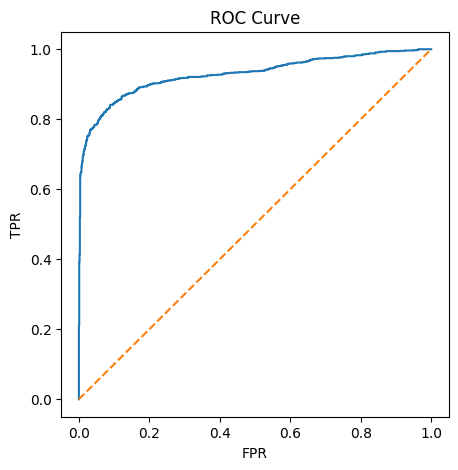

In [ ]:
# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_test_score)
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

In [ ]:
# Control del overfitting
for i in range(1,35):
    dt2 = RandomForestClassifier(max_depth=i, random_state=42, n_estimators=100)
    dt2.fit(X_train, y_train)
    acc_train = dt2.score(X_train, y_train)
    acc_test = dt2.score(X_test, y_test)
    print(f'Profundidad del arbol: {i}, Acc. train: {np.round(acc_train,3)}, Acc. test: {np.round(acc_test,3)}')

Profundidad del arbol: 1, Acc. train: 0.809, Acc. test: 0.746
Profundidad del arbol: 2, Acc. train: 0.863, Acc. test: 0.773
Profundidad del arbol: 3, Acc. train: 0.866, Acc. test: 0.779
Profundidad del arbol: 4, Acc. train: 0.866, Acc. test: 0.784
Profundidad del arbol: 5, Acc. train: 0.895, Acc. test: 0.832
Profundidad del arbol: 6, Acc. train: 0.9, Acc. test: 0.843
Profundidad del arbol: 7, Acc. train: 0.905, Acc. test: 0.854
Profundidad del arbol: 8, Acc. train: 0.91, Acc. test: 0.863
Profundidad del arbol: 9, Acc. train: 0.911, Acc. test: 0.862
Profundidad del arbol: 10, Acc. train: 0.915, Acc. test: 0.869
Profundidad del arbol: 11, Acc. train: 0.92, Acc. test: 0.869
Profundidad del arbol: 12, Acc. train: 0.923, Acc. test: 0.871
Profundidad del arbol: 13, Acc. train: 0.926, Acc. test: 0.873
Profundidad del arbol: 14, Acc. train: 0.931, Acc. test: 0.871
Profundidad del arbol: 15, Acc. train: 0.934, Acc. test: 0.874
Profundidad del arbol: 16, Acc. train: 0.939, Acc. test: 0.873
Profu

# 9. Predicción de la probabilidad de compra de un plan de pensiones para el último mes
Se realiza una predicción de la probabilidad de que cada cliente compre un plan de pensiones en el último mes. Estos resultados se ordenan por probabilidad y se guardan en un archivo CSV.

In [ ]:
# Creamos el conjunto de datos para el último mes
last_month_df = df_grouped[df_grouped['pk_partition'] == last_month]

# Excluimos a los clientes que ya tienen un plan de pensiones
last_month_df = last_month_df[last_month_df['pension_plan'] == 0]

# Excluimos las ventas
X_last_month = last_month_df[features].copy()

# Normalizamos las características numéricas
X_last_month.loc[:, numeric_features] = scaler.transform(X_last_month[numeric_features])

# Hacemos las predicciones de probabilidad con el modelo
probs = model.predict_proba(X_last_month)

# Conservamos solo la probabilidad de la clase positiva
probs = probs[:, 1]

# Creamos un DataFrame para los resultados
results = pd.DataFrame({
    'pk_cid': last_month_df['pk_cid'],  # reemplazar 'CustomerID' con tu columna de identificación de clientes
    'Probability_pension_plan': probs
})

# Ordenamos de mayor a menor probabilidad
results = results.sort_values(by='Probability_pension_plan', ascending=False)

# Mostramos los resultados
print(results)

         pk_cid  Probability_pension_plan
418713  1519449                  0.997460
414654  1514174                  0.997218
306557  1382623                  0.995947
4466     901017                  0.995877
328539  1413895                  0.995702
...         ...                       ...
185467  1228071                  0.037730
252016  1317180                  0.036632
246049  1310418                  0.036553
245714  1310043                  0.036553
254611  1320130                  0.036482

[389939 rows x 2 columns]


In [ ]:
# Vamos a revisar el número de usuarios con una probabilidad superior al 50% de comprar
results[results['Probability_pension_plan']>0.5]

,pk_cid,Probability_pension_plan
418713,1519449,0.997460
414654,1514174,0.997218
306557,1382623,0.995947
4466,901017,0.995877
328539,1413895,0.995702
...,...,...
424304,1527042,0.500010
423658,1526183,0.500009
190628,1234619,0.500008
49611,1060873,0.500007


In [ ]:
# Supongamos que 'pk_cid' es la columna con los identificadores de cliente
# y 'proba' es la columna con las probabilidades predichas
positive_cid = results[results['Probability_pension_plan'] > 0.0]['pk_cid']

# Ahora cruza esto con tu dataframe original
cross_check = df[df['pk_cid'].isin(positive_cid)]

# Verifica que todos los valores en 'pension_plan' son 0
if all(cross_check['pension_plan'] == 0):
    print("Funciona correctamente: Los resultados de probabilidad positiva tienen valor 0 en la columna!")
else:
    raise ValueError("Error en la probabilidad")

Funciona correctamente: Los resultados de probabilidad positiva tienen valor 0 en la columna!


# 10. Búsqueda de hiperparámetros óptimos
Se realiza una búsqueda aleatoria de hiperparámetros para encontrar la mejor combinación de parámetros para el modelo de Random Forest.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

## Definir el rango de parámetros para la búsqueda aleatoria
param_dist = {"max_depth": randint(10, 15),
              "n_estimators": randint(50, 100),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Crear una nueva instancia del modelo RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=50, cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Ver los mejores parámetros encontrados
print("Mejores parámetros: ", random_search.best_params_)

# Utilizar el mejor modelo para hacer predicciones
best_rf = random_search.best_estimator_


Mejores parámetros:  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 13, 'n_estimators': 79}


Probamos también con XGBoost, haciendo una búsqueda de parámetros óptimos pero el resultado era ligeramente inferior, por lo que no lo utilizamos finalmente.

# 11. Análisis de correlación de las variables con el target
Se realiza un análisis de correlación para identificar las variables que tienen una mayor correlación con la variable objetivo, lo que puede indicar qué variables son más importantes para la predicción.

In [ ]:
correlation_with_target = df_grouped.corr()[target]
correlation_with_target = correlation_with_target.drop(target)
sorted_correlations = correlation_with_target.sort_values(ascending=False)
print(sorted_correlations)

<ipython-input-35-1c63af0904c5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_target = df_grouped.corr()[target]


payroll_account               0.829244
debit_card                    0.341882
credit_card                   0.170733
segment_02 - PARTICULARES     0.164972
entry_channel_KFC             0.137452
                                ...   
pk_cid                       -0.035245
entry_channel_KHQ            -0.103414
entry_channel_KHE            -0.138928
segment_03 - UNIVERSITARIO   -0.168028
em_acount                    -0.248653
Name: pension_plan, Length: 86, dtype: float64


In [ ]:
corr = df_grouped.corr()

<ipython-input-36-27b27b39aada>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_grouped.corr()


In [ ]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 443658 entries, 239167 to 443657
Data columns (total 88 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   pk_cid                      443658 non-null  int64         
 1   pension_plan                443658 non-null  int64         
 2   age                         443658 non-null  int64         
 3   salary                      443658 non-null  float64       
 4   loans                       443658 non-null  int64         
 5   mortgage                    443658 non-null  int64         
 6   funds                       443658 non-null  int64         
 7   securities                  443658 non-null  int64         
 8   long_term_deposit           443658 non-null  int64         
 9   credit_card                 443658 non-null  int64         
 10  payroll_account             443658 non-null  int64         
 11  emc_account                 443658

In [ ]:
corr.style.background_gradient(cmap='coolwarm')

# 12. Descargamos el archivo con la propabilidad por cliente

In [ ]:
from google.colab import files

# Guardar el dataframe en un archivo CSV
results.to_csv('results_pension_plan.csv', index=False)

# Descargar el archivo CSV
files.download('results_pension_plan.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>